In [1]:
import numpy as np
import pymc as pm

from pymmmc.distributions import continuous_contractual, continuous_non_contractual

from lifetimes.datasets import load_cdnow_summary

from scipy.special import expit, hyp2f1

import xarray as xr

import matplotlib.pyplot as plt

In [2]:
a = 0.8
b = 2.5
alpha = 3
r = 4

rng = np.random.default_rng(seed=34)

df = load_cdnow_summary(index_col=[0])
T = df["T"].values

In [3]:
def rng_fn(rng, a, b, r, alpha, T, T0, size):
    p = rng.beta(a, b, size=size)
    lam = rng.gamma(r, 1 / alpha, size=size)

    return continuous_contractual.rng_fn(rng, lam, p, T, T0, size=size)

In [4]:
data = rng_fn(rng, a, b, r, alpha, T, 0, size=len(T))

In [5]:
recency = data[..., 0]
frequency = data[..., 1]
alive = 1 - data[..., 2]

In [6]:
def conditional_probability_alive_lifetimes(
    frequency, 
    recency, 
    T
):
    log_div = (r + frequency) * np.log((alpha + T) / (alpha + recency)) + np.log(
        a / (b + np.maximum(frequency, 1) - 1)
    )

    return np.atleast_1d(np.where(frequency == 0, 1.0, expit(-log_div)))

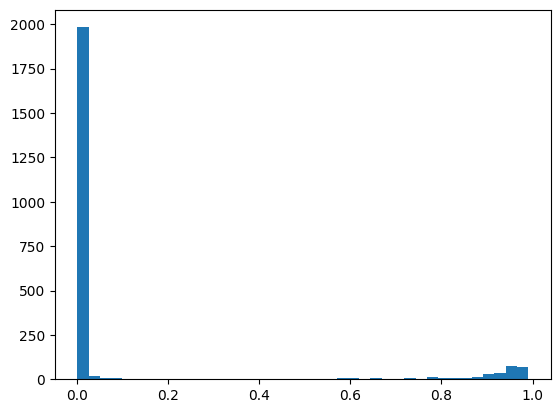

In [7]:
plt.hist(conditional_probability_alive_lifetimes(frequency, recency, T), bins=40);

In [8]:
with pm.Model() as model:
    pm.Normal("a", a, sigma=0.1)
    pm.Normal("b", b, sigma=0.1)
    pm.Normal("alpha", alpha, sigma=0.1)
    pm.Normal("r", r, sigma=0.1)
    
    trace = pm.sample(chains=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, alpha, r]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 12 seconds.


In [9]:
trace

Inference data with groups:
	> posterior
	> sample_stats

In [10]:
dims = ("customer_id",)
coords = {"customer_id": range(len(frequency))}

frequency = xr.DataArray(
    frequency, 
    dims=dims,
    coords=coords,
)

recency = xr.DataArray(
    recency, 
    dims=dims,
    coords=coords,
)

T = xr.DataArray(
    T, 
    dims=dims,
    coords=coords,
)

In [11]:
def conditional_probability_alive(frequency, recency, T, trace):

    dims = ("customer_id",)
    coords = {"customer_id": range(len(frequency))}
    
    to_xarray = lambda array: xr.DataArray(data=array, coords=coords, dims=dims)

    frequency = to_xarray(frequency)
    recency = to_xarray(recency)
    T = to_xarray(T)
    
    a = trace.posterior["a"]
    b = trace.posterior["b"]
    alpha = trace.posterior["alpha"]
    r = trace.posterior["r"]
    
    log_div = (r + frequency) * np.log((alpha + T) / (alpha + recency)) + np.log(
        a / (b + np.maximum(frequency, 1) - 1)
    )

    return xr.where(frequency == 0, 1.0, expit(-log_div))

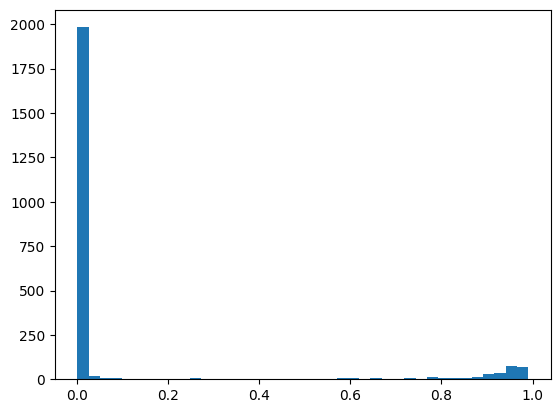

In [12]:
plt.hist(conditional_probability_alive(frequency, recency, T, trace).mean(("draw", "chain")), bins=40);

In [13]:
trace.posterior["a"].mean()

<xarray.DataArray 'a' ()>
array(0.80058597)

In [14]:
def expected_number_of_purchases(t, frequency, recency, T):
    numerator = 1 - ((alpha + T) / (alpha + T + t)) ** (r + frequency) * hyp2f1(
        r + frequency,
        b + frequency,
        a + b + frequency - 1,
        t / (alpha + T + t),
    )
    numerator *= (a + b + frequency - 1) / (a - 1)
    denominator = 1 + (frequency > 0) * (a / (b + frequency - 1)) * (
        (alpha + T) / (alpha + recency)
    ) ** (r + frequency)
    
    return numerator/denominator

In [15]:
def to_xarray(*arrays):
    num_customers = len(arrays[0])
    dims = ("customer_id",)
    coords = {"customer_id": range(num_customers)}

    if len(arrays) == 1:
        return xr.DataArray(data=arrays[0], coords=coords, dims=dims)

    if any(len(array) != num_customers for array in arrays):
        raise ValueError("The size of input arrays must be the same.")

    return (xr.DataArray(data=array, coords=coords, dims=dims) for array in arrays)

frequency, recency, T = to_xarray(frequency, recency, T)

t = xr.DataArray(
    range(20, 40, 2),
    coords={"times": range(10)},
    dims=("times",),
)
expected_number_of_purchases_new_customer(t, frequency, recency, T)

<xarray.DataArray (customer_id: 2357, times: 10)>
array([[1.24383802e+01, 1.34879227e+01, 1.45105754e+01, ...,
        1.92688909e+01, 2.01577586e+01, 2.10280203e+01],
       [1.40509154e-07, 1.52093799e-07, 1.63348148e-07, ...,
        2.15314049e-07, 2.24954275e-07, 2.34373811e-07],
       [8.33117474e-05, 9.01011987e-05, 9.66872364e-05, ...,
        1.26980810e-04, 1.32580942e-04, 1.38047343e-04],
       ...,
       [1.81728791e-05, 1.96313117e-05, 2.10438465e-05, ...,
        2.75171216e-05, 2.87100928e-05, 2.98736204e-05],
       [3.65527293e-04, 3.93375244e-04, 4.20185039e-04, ...,
        5.41215146e-04, 5.63223769e-04, 5.84608832e-04],
       [2.65302833e-05, 2.86050981e-05, 3.06086185e-05, ...,
        3.97219388e-05, 4.13903545e-05, 4.30145687e-05]])
Coordinates:
  * customer_id  (customer_id) int64 0 1 2 3 4 5 ... 2352 2353 2354 2355 2356
  * times        (times) int64 0 1 2 3 4 5 6 7 8 9

In [16]:
to_xarray = lambda array: xr.DataArray(array,
    coords={"customer_id": range(len(array))},
    dims=("customer_id",),
)
t = to_xarray(range(20, 40, 2))
frequency = to_xarray([1, 3, 5, 7, 9]*2)
recency = to_xarray([20, 30]*5)
T = to_xarray([25, 35]*5)

In [17]:
expected_number_of_purchases_new_customer(t, frequency, recency, T)

<xarray.DataArray (customer_id: 10)>
array([1.42554638, 2.17059763, 3.29959668, 4.06284244, 4.72380438,
       1.73223875, 3.1645582 , 4.08454744, 5.20603817, 6.34220761])
Coordinates:
  * customer_id  (customer_id) int64 0 1 2 3 4 5 6 7 8 9